In [6]:
!pip install -q librosa soundfile

import warnings
warnings.filterwarnings("ignore")

import os
import time
import csv
import librosa
import soundfile as sf
from base64 import b64decode
from google.colab.output import eval_js
from IPython.display import display, HTML, Audio, clear_output  # clear_output 추가

# ─── 1. Tacotron 학습용 대본 리스트 ────────────────────────────────────────────
"""
scripts = [
     "안녕하세요, 저는 오늘 학교에 갔습니다.",
     "날씨가 참 맑고 기분이 좋네요.",
     "커피 한 잔 마시며 책을 읽고 있습니다.",
     "저녁에 친구들과 영화를 보러 갈 예정입니다.",
     "새로운 취미로 그림 그리기를 시작했습니다.",
     "매일 아침 조깅을 할 때 상쾌함을 느낍니다.",
     "저는 음악을 들으며 공부하는 것을 좋아합니다.",
     "주말에는 가족과 함께 공원에 갑니다.",
     "다음 주에 중요한 발표가 있습니다.",
     "저는 한국어를 배우고 있습니다."
 ]
"""
scripts = [
     "오늘 합격 발표를 보고 정말 기뻤어요",
     "오랫동안 기다리던 선물을 받아서 행복합니다.",
     "친구들이 축하해 주어서 마음이 따뜻해요.",
     "맛있는 음식을 먹으니 기분이 좋아지네요.",
     "여행을 떠나기 전에 설레는 마음이 듭니다.",
 ] # 기쁨
"""
scripts = [
    "오랜 친구가 멀리 이사 가서 마음이 아파요",
    "기대했던 공연이 취소되어서 많이 슬펐습니다.",
    "비가 오는 날이면 자꾸 생각이 많아져요.",
    "소중한 물건을 잃어버려서 안타깝습니다.",
    "영화의 마지막 장면이 너무 슬펐어요.",
] # 슬픔
"""
# ─── 2. 녹음 파일 저장 디렉터리 및 메타 리스트 ───────────────────────────────
os.makedirs("recordings", exist_ok=True)
metadata = []

# ─── 3. 녹음 및 WAV 변환 함수 ─────────────────────────────────────────────────
def record_script(text, filename, duration=7):
    clear_output(wait=True)        # 이전 출력 내용 모두 삭제
    display(HTML(f"<h3>다음 문장을 따라 읽어주세요:</h3>"
                 f"<p style='font-size:20px;'>{text}</p>"))

    js = f"""
(async () => {{
  const duration = {duration};
  const timerDiv = document.createElement('div');
  timerDiv.id = 'countdown';
  timerDiv.style.fontSize = '20px';
  timerDiv.style.marginBottom = '10px';
  document.body.appendChild(timerDiv);

  const stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
  const recorder = new MediaRecorder(stream);
  const chunks = [];
  recorder.ondataavailable = e => chunks.push(e.data);
  recorder.start();

  for (let i = duration; i >= 0; i--) {{
    timerDiv.innerText = `녹음 중: ${{i}}초 남음`;
    await new Promise(r => setTimeout(r, 1000));
  }}

  recorder.stop();
  await new Promise(r => recorder.onstop = r);
  timerDiv.innerText = '녹음 완료!';
  const blob = new Blob(chunks);
  const reader = new FileReader();
  reader.readAsDataURL(blob);
  await new Promise(r => reader.onloadend = r);
  timerDiv.remove();
  return reader.result.split(',')[1];
}})();
    """
    b64data = eval_js(js)
    audio_bytes = b64decode(b64data)

    path_webm = os.path.join("recordings", filename + ".webm")
    with open(path_webm, "wb") as f:
        f.write(audio_bytes)

    audio, sr = librosa.load(path_webm, sr=16000)
    path_wav = os.path.join("recordings", filename + ".wav")
    sf.write(path_wav, audio, sr, subtype='PCM_16')
    os.remove(path_webm)

    clear_output(wait=True)        # 녹음 후에도 출력 영역을 초기화
    print(f"저장 완료 (WAV): {path_wav}")
    #display(Audio(path_wav, autoplay=False))
    return path_wav


In [2]:

# ─── 4. 대본별 순차 녹음 진행 ──────────────────────────────────────────────────
for idx, text in enumerate(scripts, start=1):
    fname = f"neutral_{idx:02d}"
    wav_path = record_script(text, fname, duration=7)
    metadata.append((wav_path, text))
    time.sleep(1)

# ─── 5. CSV로 대본 메타데이터 저장 ─────────────────────────────────────────────
csv_path = os.path.join("recordings", "transcripts.csv")
with open(csv_path, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "transcript"])
    for wav_path, transcript in metadata:
        writer.writerow([os.path.basename(wav_path), transcript])

clear_output(wait=True)
print(f"모든 녹음 완료! 대본 CSV 저장: {csv_path}")

NameError: name 'scripts' is not defined

화자인증 및 감정분석

In [1]:
!pip install -q numpy scikit-learn matplotlib
!pip install -q librosa soundfile
!pip install -q torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.6 MB/s eta 0:00:00


In [2]:
!unzip -o 김희건_emotion.zip -d /content/data
!unzip -o 김희건_speaker.zip -d /content/data

Archive:  김희건_emotion.zip
   creating: /content/data/emotion/
  inflating: /content/data/emotion/anger_01.wav  
  inflating: /content/data/emotion/anger_02.wav  
  inflating: /content/data/emotion/anger_03.wav  
  inflating: /content/data/emotion/anger_04.wav  
  inflating: /content/data/emotion/anger_05.wav  
  inflating: /content/data/emotion/joy_01.wav  
  inflating: /content/data/emotion/joy_02.wav  
  inflating: /content/data/emotion/joy_03.wav  
  inflating: /content/data/emotion/joy_04.wav  
  inflating: /content/data/emotion/joy_05.wav  
  inflating: /content/data/emotion/neutral_01.wav  
  inflating: /content/data/emotion/neutral_02.wav  
  inflating: /content/data/emotion/neutral_03.wav  
  inflating: /content/data/emotion/neutral_04.wav  
  inflating: /content/data/emotion/neutral_05.wav  
  inflating: /content/data/emotion/sad_01.wav  
  inflating: /content/data/emotion/sad_02.wav  
  inflating: /content/data/emotion/sad_03.wav  
  inflating: /content/data/emotion/sad_04.wa

Epoch 01  loss 4.5198  spk_acc 1.0000  emo_acc 0.5000
Epoch 02  loss 6.4878  spk_acc 1.0000  emo_acc 0.0000
Epoch 03  loss 5.2737  spk_acc 1.0000  emo_acc 0.0000
Epoch 04  loss 4.2265  spk_acc 1.0000  emo_acc 1.0000
Epoch 05  loss 2.7597  spk_acc 1.0000  emo_acc 1.0000
Epoch 06  loss 5.3673  spk_acc 1.0000  emo_acc 0.5000
Epoch 07  loss 3.2247  spk_acc 1.0000  emo_acc 0.5000
Epoch 08  loss 4.4261  spk_acc 1.0000  emo_acc 0.5000
Epoch 09  loss 4.2050  spk_acc 1.0000  emo_acc 0.5000
Epoch 10  loss 2.1454  spk_acc 1.0000  emo_acc 0.0000
Epoch 11  loss 4.2260  spk_acc 1.0000  emo_acc 0.0000
Epoch 12  loss 4.0203  spk_acc 1.0000  emo_acc 0.0000
Epoch 13  loss 4.2379  spk_acc 1.0000  emo_acc 0.5000
Epoch 14  loss 2.1657  spk_acc 1.0000  emo_acc 1.0000
Epoch 15  loss 3.1710  spk_acc 1.0000  emo_acc 0.5000
Epoch 16  loss 2.7520  spk_acc 1.0000  emo_acc 0.5000
Epoch 17  loss 2.7166  spk_acc 1.0000  emo_acc 0.5000
Epoch 18  loss 3.0277  spk_acc 1.0000  emo_acc 0.5000
Epoch 19  loss 2.2017  spk_a

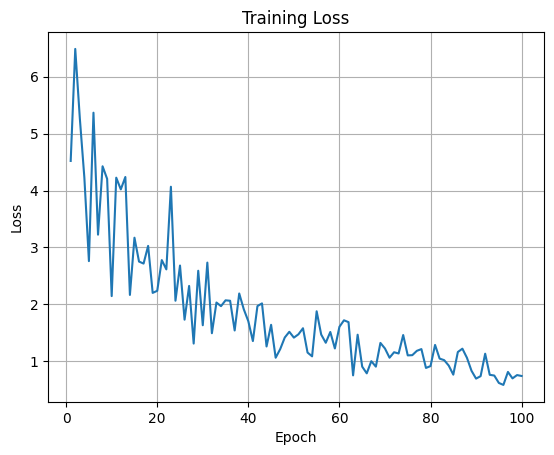

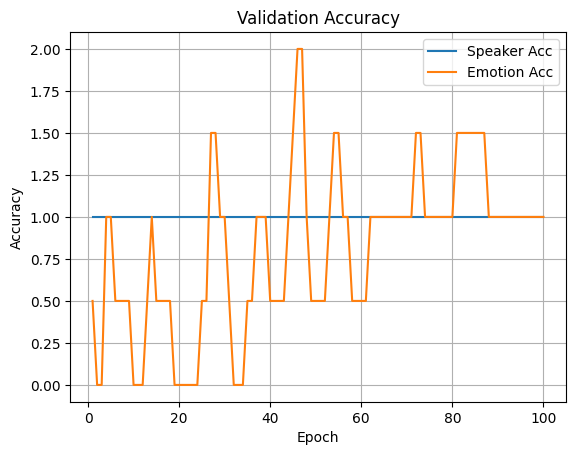

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# 1) 데이터셋 클래스 정의
class VoiceDataset(Dataset):
    def __init__(self, file_list, label_list, sr=16000, n_mfcc=40):
        self.files = file_list
        self.labels = label_list
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.le = LabelEncoder().fit(label_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        y, _ = librosa.load(path, sr=self.sr)
        mfcc = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=self.n_mfcc)
        feat = np.concatenate([mfcc.mean(axis=1), mfcc.std(axis=1)])
        label = self.labels[idx]
        return torch.FloatTensor(feat), torch.LongTensor([self.le.transform([label])[0]])

# 2) 데이터 로딩 및 분할
spk_files = sorted([f"/content/data/speaker/{f}" for f in os.listdir("/content/data/speaker")])
spk_labels = [os.path.splitext(os.path.basename(f))[0].split("_")[0] for f in spk_files]#label을 _로 구분 즉 파일이름 중 _앞에 있는 부분을 label로 인식
ds_spk = VoiceDataset(spk_files, spk_labels)

emo_files = sorted([f"/content/data/emotion/{f}" for f in os.listdir("/content/data/emotion")])
emo_labels = [os.path.splitext(os.path.basename(f))[0].split("_")[0] for f in emo_files]
ds_emo = VoiceDataset(emo_files, emo_labels)

train_spk, val_spk = random_split(ds_spk, [int(len(ds_spk)*0.8), len(ds_spk)-int(len(ds_spk)*0.8)])
train_emo, val_emo = random_split(ds_emo, [int(len(ds_emo)*0.8), len(ds_emo)-int(len(ds_emo)*0.8)])

loader_spk = DataLoader(train_spk, batch_size=16, shuffle=True)
loader_emo = DataLoader(train_emo, batch_size=16, shuffle=True)
val_loader_spk = DataLoader(val_spk, batch_size=16)
val_loader_emo = DataLoader(val_emo, batch_size=16)

# 3) 모델 정의
class MultiTaskModel(nn.Module):  #두개의 파이프라인이 동시에 실행
    def __init__(self, input_dim, spk_classes, emo_classes):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU()
        ) #여기에서 기본적으로 처리한다.
        self.fc_spk = nn.Linear(128, spk_classes) #speaker에 대한 layer
        self.fc_emo = nn.Linear(128, emo_classes) #emotion에 대한 layer

    def forward(self, x): #순방향 algorithm
        h = self.shared(x)
        return self.fc_spk(h), self.fc_emo(h)

# 4) 학습 루프 + 기록 리스트 준비
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel(input_dim=80,
                       spk_classes=len(set(spk_labels)),
                       emo_classes=len(set(emo_labels))).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3) #경사하강법을 쓰는 최적화 algorithm
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_acc_spk = []
val_acc_emo = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for (x_spk, y_spk), (x_emo, y_emo) in zip(loader_spk, loader_emo):
        x = torch.cat([x_spk, x_emo], dim=0).to(device)
        y_spk = y_spk.squeeze().to(device)
        y_emo = y_emo.squeeze().to(device)

        out_spk, out_emo = model(x)
        loss = loss_fn(out_spk[:len(y_spk)], y_spk) \
             + loss_fn(out_emo[len(y_spk):], y_emo)

        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader_spk)
    train_losses.append(avg_loss)

    # 검증 정확도 계산
    model.eval()
    correct_s = correct_e = total = 0
    with torch.no_grad():
        for (vx_spk, vy_spk), (vx_emo, vy_emo) in zip(val_loader_spk, val_loader_emo):
            x_val = torch.cat([vx_spk, vx_emo], dim=0).to(device)
            vy_spk = vy_spk.squeeze().to(device)
            vy_emo = vy_emo.squeeze().to(device)
            out_s, out_e = model(x_val)
            pred_s = out_s[:len(vy_spk)].argmax(1)
            pred_e = out_e[len(vy_spk):].argmax(1)
            correct_s += (pred_s == vy_spk).sum().item()
            correct_e += (pred_e == vy_emo).sum().item()
            total += len(vy_spk)

    val_acc_spk.append(correct_s / total)
    val_acc_emo.append(correct_e / total)

    print(f"Epoch {epoch+1:02d}  loss {avg_loss:.4f}  spk_acc {val_acc_spk[-1]:.4f}  emo_acc {val_acc_emo[-1]:.4f}")

# 5) 학습 결과 시각화
#   - 학습 손실
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid("true")
plt.show()

#   - 검증 정확도 (화자 vs 감정)
plt.figure()
plt.plot(range(1, len(val_acc_spk)+1), val_acc_spk, label="Speaker Acc")
plt.plot(range(1, len(val_acc_emo)+1), val_acc_emo, label="Emotion Acc")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid("true")
plt.legend()
plt.show()

In [5]:
# 6) 실시간 테스트 예시
def test(test_path):
  y, _ = librosa.load(test_path, sr=16000)
  mfcc = librosa.feature.mfcc(y=y, sr=16000, n_mfcc=40)
  feat = np.concatenate([mfcc.mean(axis=1), mfcc.std(axis=1)])
  feat_tensor = torch.FloatTensor(feat).unsqueeze(0).to(device)

  model.eval()
  spk_out, emo_out = model(feat_tensor)
  pred_spk = ds_spk.le.inverse_transform([spk_out.argmax(1).item()])[0]
  pred_emo = ds_emo.le.inverse_transform([emo_out.argmax(1).item()])[0]
  print("예측 화자:", pred_spk)
  print("예측 감정:", pred_emo)

In [6]:
test("/content/data/emotion/anger_01.wav")
test("/content/data/emotion/joy_01.wav")
test("/content/data/emotion/anger_03.wav")
test("/content/data/emotion/neutral_01.wav")


예측 화자: 김희건
예측 감정: anger
예측 화자: 김희건
예측 감정: joy
예측 화자: 김희건
예측 감정: anger
예측 화자: 김희건
예측 감정: anger


연습문제

1. 음성 화자인식

In [31]:
import os
import glob
import numpy as np
import torch
import torchaudio
import joblib
import warnings
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Wav2Vec2FeatureExtractor, WavLMModel
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)


In [32]:
!unzip -o vocie_fishing.zip -d /content

Archive:  vocie_fishing.zip
  inflating: /content/vocie_fishing_조은별/vf_조은별_01.wav  
  inflating: /content/vocie_fishing_조은별/vf_조은별_02.wav  
  inflating: /content/vocie_fishing_조은별/vf_조은별_03.wav  
  inflating: /content/vocie_fishing_조은별/vf_조은별_04.wav  
  inflating: /content/vocie_fishing_조은별/vf_조은별_05.wav  
  inflating: /content/vocie_fishing_조은별/vf_조은별_06.wav  
  inflating: /content/vocie_fishing_조은별/vf_조은별_07.wav  
  inflating: /content/vocie_fishing_조은별/vf_조은별_08.wav  
  inflating: /content/vocie_fishing_조은별/vf_조은별_09.wav  
  inflating: /content/vocie_fishing_조은별/vf_조은별_10.wav  


In [33]:
# 1) 데이터 & 라벨 준비
DATA_DIR = "/content/vocie_fishing_조은별"
wav_paths = sorted(glob.glob(os.path.join(DATA_DIR, "vf_*.wav")))
labels = [
    "".join(filter(str.isalpha, os.path.basename(p).replace("vf_","").replace(".wav","")))
    for p in wav_paths
]

Epoch 01 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 02 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 03 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 04 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 05 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 06 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 07 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 08 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 09 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 10 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 11 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 12 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 13 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 14 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 15 | Train L=0.0000 Acc=1.0000 | Val   L=0.0000 Acc=1.0000
Epoch 16 | Train L=0.0000

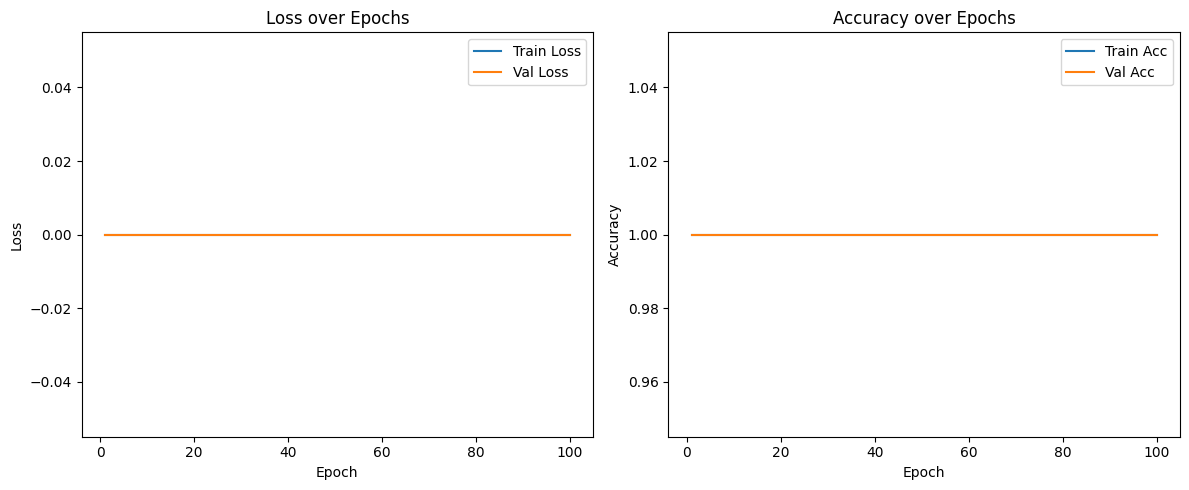

['model_sa_s/label_encoder.joblib']

In [34]:
le = LabelEncoder()
y = le.fit_transform(labels)
num_classes = len(le.classes_)

# 2) WavLM 임베딩 준비
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feat_ext = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")
wavlm    = WavLMModel.from_pretrained("microsoft/wavlm-base-plus").to(device)
wavlm.eval()
def extract_embedding(path):
    wav, sr = torchaudio.load(path)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    inp = feat_ext(wav.squeeze().numpy(), sampling_rate=16000, return_tensors="pt")
    inp = {k: v.to(device) for k, v in inp.items()}
    with torch.no_grad():
        out = wavlm(**inp).last_hidden_state  # [1, T, D]
    return out.mean(dim=1)[0]               # Tensor shape (768,)

# 3) Dataset & DataLoader
class SpkDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths, self.labels = paths, labels
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        return extract_embedding(self.paths[idx]), self.labels[idx]

dataset = SpkDataset(wav_paths, y)
n_total = len(dataset)
n_train = max(int(0.8 * n_total), 1)
n_val   = n_total - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=min(16, n_train), shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=min(16, n_val), shuffle=False)

# 4) 개선된 MLP 헤드 (BatchNorm + Dropout)
class SpeakerAuthNet(nn.Module):
    def __init__(self, in_dim=768, hidden1=512, hidden2=256, num_classes=num_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.fc3 = nn.Linear(hidden2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout(torch.relu(self.bn2(self.fc2(x))))
        return self.fc3(x)

model_sa = SpeakerAuthNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sa.parameters(), lr=1e-4)

# 5) Training loop with history logging
epochs = 100
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, epochs+1):
    model_sa.train()
    tloss = tcorrect = tsamples = 0
    for emb, lbl in train_loader:
        emb, lbl = emb.to(device), lbl.to(device)
        logits = model_sa(emb)
        loss = criterion(logits, lbl)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tloss += loss.item() * emb.size(0)
        tcorrect += (logits.argmax(dim=1) == lbl).sum().item()
        tsamples += emb.size(0)
    train_loss = tloss/tsamples
    train_acc  = tcorrect/tsamples

    model_sa.eval()
    vloss = vcorrect = vsamples = 0
    with torch.no_grad():
        for emb, lbl in val_loader:
            emb, lbl = emb.to(device), lbl.to(device)
            logits = model_sa(emb)
            loss = criterion(logits, lbl)
            vloss += loss.item() * emb.size(0)
            vcorrect += (logits.argmax(dim=1) == lbl).sum().item()
            vsamples += emb.size(0)
    val_loss = vloss/max(vsamples,1)
    val_acc  = vcorrect/max(vsamples,1)

    # record history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train L={train_loss:.4f} Acc={train_acc:.4f} | "
          f"Val   L={val_loss:.4f} Acc={val_acc:.4f}")

# 6) 성능 시각화
epochs_range = range(1, epochs+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses,   label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs,   label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 7) 저장
os.makedirs("model_sa_s", exist_ok=True)
torch.save(model_sa.state_dict(), "model_sa_s/speaker_auth_net.pth")
joblib.dump(le, "model_sa_s/label_encoder.joblib")

In [36]:
import os
import torch
import torchaudio
import joblib
from transformers import Wav2Vec2FeatureExtractor, WavLMModel
import torch
import torch.nn.functional as F

# 1) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Label encoder load
le = joblib.load("model_sa_s/label_encoder.joblib")

# 3) Model definition matching saved keys
class SpeakerAuthNet(torch.nn.Module):
    def __init__(self, in_dim=768, hidden1=512, hidden2=256, num_classes=len(le.classes_)):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_dim, hidden1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)
        self.fc2 = torch.nn.Linear(hidden1, hidden2)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)
        self.fc3 = torch.nn.Linear(hidden2, num_classes)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout(torch.relu(self.bn2(self.fc2(x))))
        return self.fc3(x)

model_sa = SpeakerAuthNet().to(device)
model_sa.load_state_dict(torch.load("model_sa_s/speaker_auth_net.pth", map_location=device))
model_sa.eval()

# 4) WavLM embedding setup
feat_ext = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")
wavlm    = WavLMModel.from_pretrained("microsoft/wavlm-base-plus").to(device)
wavlm.eval()

def extract_embedding(path):
    wav, sr = torchaudio.load(path)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    inp = feat_ext(wav.squeeze().numpy(), sampling_rate=16000, return_tensors="pt")
    inp = {k: v.to(device) for k, v in inp.items()}
    with torch.no_grad():
        out = wavlm(**inp).last_hidden_state
    return out.mean(dim=1)[0]

# 5) Updated inference function without threshold
def infer_speaker(wav_path):
    emb = extract_embedding(wav_path).unsqueeze(0).to(device)
    logits = model_sa(emb)
    probs = F.softmax(logits, dim=1)[0]
    best_idx = probs.argmax().item()
    best_prob = probs[best_idx].item()
    speaker = le.inverse_transform([best_idx])[0]
    if best_prob>0.8:
      print(f"{speaker}님은 동록된 사용자입니다. (confidence: {best_prob:.2f})")
    else:
      print(f"누구십니까? (confidence: {best_prob:.2f})")
    return best_prob


보이스피싱 가능성 문장인식

1. STT

In [37]:
import warnings
warnings.filterwarnings("ignore")

import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
from base64 import b64decode
from google.colab.output import eval_js
from IPython.display import display, Audio
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Whisper STT 모델
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model_whi = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)


In [40]:
def transcribe_file(path):
    import soundfile as sf
    import librosa
    try:
        audio, sr = sf.read(path)
    except:
        audio, sr = librosa.load(path, sr=16000)
    inputs = processor(audio, sampling_rate=sr, return_tensors="pt", padding=True)
    input_features = inputs.input_features.to(device)

    encoder = model_whi.model.encoder
    stride1 = encoder.conv1.stride[0]
    stride2 = encoder.conv2.stride[0]
    expected_len = model_whi.config.max_source_positions * stride1 * stride2

    seq_len = input_features.shape[-1]
    if seq_len < expected_len:
        pad_len = expected_len - seq_len
        input_features = torch.nn.functional.pad(input_features, (0, pad_len))
    elif seq_len > expected_len:
        input_features = input_features[..., :expected_len]

    attention_mask = torch.ones(input_features.shape[:-1], device=device)

    with torch.no_grad():
        predicted_ids = model_whi.generate(
            input_features=input_features,
            language="ko",
            attention_mask=attention_mask
        )
    return processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

# 2) SentenceTransformer 임베딩 모델 로드
embedder = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens').to(device)

# 3) 예약 관련 FAQ 예시 데이터 (질문과 답변)
#BERT를 사용하기에 사용자의 음성이 question과 약간 달라도, 각 question에 대해 가장 score가 높은 문장을 인식하고
#그에 대한 답변을 출력한다.
faq = [
    {"question": "안녕하세요, 고객님. 저희 국민은행 보안팀입니다. 고객님의 계좌에서 이상 거래가 탐지되어 긴급 확인이 필요합니다.", "answer": "넵"},
    {"question": "고객님, 경찰청 사이버수사대입니다. 최근 고객님 명의로 대포통장이 개설된 정황이 있어 즉시 출석 요청드립니다.", "answer": "넵"},
    {"question": "안녕하십니까, 국세청입니다. 고객님의 사업자 등록번호에 탈세 혐의가 있어 세무조사가 예정되어 있습니다.", "answer": "넵"},
    {"question": "고객님, SKT 모바일 고객센터인데요. 요금 결제 오류로 인해 서비스가 중단될 위기에 있으니 즉시 결제 승인 부탁드립니다.", "answer": "넵"},
    {"question": "미래보험 고객님, 계약 갱신이 완료되지 않아 보장 혜택이 중단될 예정입니다. 지금 바로 카드 번호를 알려주세요.", "answer": "넵"},
    {"question": "안녕하세요, 카카오뱅크입니다. 보안 강화 차원에서 고객님의 로그인 정보를 재등록하셔야 합니다. 인증번호를 입력해주세요.", "answer": "넵"},
    {"question": "고객님, 인터넷뱅킹 사기 예방 서비스입니다. 현재 이체 요청이 접수돼 있는데, 본인 확인을 위해 카드 뒷면 CVC 코드를 불러주세요.", "answer": "넵"},
    {"question": "안녕하십니까, 국민연금공단입니다. 최근 납부 내역에 이상이 있어 연금 수급이 중단될 수 있으니 긴급 확인 바랍니다.", "answer": "넵"},
    {"question": "고객님, 우체국택배입니다. 배송 대금이 미결제돼 있어 물건 수령이 불가합니다. 결제 정보를 다시 알려주시겠습니까?", "answer": "넵"},
    {"question": "안녕하세요, 대법원 등기소입니다. 부동산 등기 촉탁이 접수되어 추가 수수료 입금이 필요합니다. 계좌번호를 알려주세요.", "answer": "넵"},
]
# 4) FAQ 질문들 임베딩 미리 계산 (GPU 사용)
faq_questions = [item['question'] for item in faq]
faq_embeddings = embedder.encode(faq_questions, convert_to_tensor=True, device=device)

# 5) 유사도 기반 답변 찾기 함수
def find_best_answer(query, threshold=0.5):
    query_emb = embedder.encode(query, convert_to_tensor=True, device=device)
    cosine_scores = util.cos_sim(query_emb, faq_embeddings)
    best_score, best_idx = torch.max(cosine_scores, dim=1)
    best_score = best_score.item()
    best_idx = best_idx.item()
    print("유사도: %lf"%best_score)
    if best_score < threshold:
        print("죄송합니다, 질문을 이해하지 못했습니다. 다시 말씀해 주세요.")
    else:
        answer=faq[best_idx]['answer']
        print(f"검색된 답변: {answer}")
    return best_score

감정분석

In [ ]:
!pip install -q numpy scikit-learn matplotlib
!pip install -q librosa soundfile
!pip install -q torch torchvision torchaudio

In [ ]:
!unzip -o 김희건_emotion.zip -d /content/data
!unzip -o 김희건_speaker.zip -d /content/data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# 1) 데이터셋 클래스 정의
class VoiceDataset(Dataset):
    def __init__(self, file_list, label_list, sr=16000, n_mfcc=40):
        self.files = file_list
        self.labels = label_list
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.le = LabelEncoder().fit(label_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        y, _ = librosa.load(path, sr=self.sr)
        mfcc = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=self.n_mfcc)
        feat = np.concatenate([mfcc.mean(axis=1), mfcc.std(axis=1)])
        label = self.labels[idx]
        return torch.FloatTensor(feat), torch.LongTensor([self.le.transform([label])[0]])

# 2) 데이터 로딩 및 분할
spk_files = sorted([f"/content/data/speaker/{f}" for f in os.listdir("/content/data/speaker")])
spk_labels = [os.path.splitext(os.path.basename(f))[0].split("_")[0] for f in spk_files]#label을 _로 구분 즉 파일이름 중 _앞에 있는 부분을 label로 인식
ds_spk = VoiceDataset(spk_files, spk_labels)

emo_files = sorted([f"/content/data/emotion/{f}" for f in os.listdir("/content/data/emotion")])
emo_labels = [os.path.splitext(os.path.basename(f))[0].split("_")[0] for f in emo_files]
ds_emo = VoiceDataset(emo_files, emo_labels)

train_spk, val_spk = random_split(ds_spk, [int(len(ds_spk)*0.8), len(ds_spk)-int(len(ds_spk)*0.8)])
train_emo, val_emo = random_split(ds_emo, [int(len(ds_emo)*0.8), len(ds_emo)-int(len(ds_emo)*0.8)])

loader_spk = DataLoader(train_spk, batch_size=16, shuffle=True)
loader_emo = DataLoader(train_emo, batch_size=16, shuffle=True)
val_loader_spk = DataLoader(val_spk, batch_size=16)
val_loader_emo = DataLoader(val_emo, batch_size=16)

# 3) 모델 정의
class MultiTaskModel(nn.Module):  #두개의 파이프라인이 동시에 실행
    def __init__(self, input_dim, spk_classes, emo_classes):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU()
        ) #여기에서 기본적으로 처리한다.
        self.fc_spk = nn.Linear(128, spk_classes) #speaker에 대한 layer
        self.fc_emo = nn.Linear(128, emo_classes) #emotion에 대한 layer

    def forward(self, x): #순방향 algorithm
        h = self.shared(x)
        return self.fc_spk(h), self.fc_emo(h)

# 4) 학습 루프 + 기록 리스트 준비
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mul = MultiTaskModel(input_dim=80,
                       spk_classes=len(set(spk_labels)),
                       emo_classes=len(set(emo_labels))).to(device)
opt = optim.Adam(model_mul.parameters(), lr=1e-3) #경사하강법을 쓰는 최적화 algorithm
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_acc_spk = []
val_acc_emo = []

for epoch in range(100):
    model_mul.train()
    total_loss = 0
    for (x_spk, y_spk), (x_emo, y_emo) in zip(loader_spk, loader_emo):
        x = torch.cat([x_spk, x_emo], dim=0).to(device)
        y_spk = y_spk.squeeze().to(device)
        y_emo = y_emo.squeeze().to(device)

        out_spk, out_emo = model_mul(x)
        loss = loss_fn(out_spk[:len(y_spk)], y_spk) \
             + loss_fn(out_emo[len(y_spk):], y_emo)

        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader_spk)
    train_losses.append(avg_loss)

    # 검증 정확도 계산
    model_mul.eval()
    correct_s = correct_e = total = 0
    with torch.no_grad():
        for (vx_spk, vy_spk), (vx_emo, vy_emo) in zip(val_loader_spk, val_loader_emo):
            x_val = torch.cat([vx_spk, vx_emo], dim=0).to(device)
            vy_spk = vy_spk.squeeze().to(device)
            vy_emo = vy_emo.squeeze().to(device)
            out_s, out_e = model_mul(x_val)
            pred_s = out_s[:len(vy_spk)].argmax(1)
            pred_e = out_e[len(vy_spk):].argmax(1)
            correct_s += (pred_s == vy_spk).sum().item()
            correct_e += (pred_e == vy_emo).sum().item()
            total += len(vy_spk)

    val_acc_spk.append(correct_s / total)
    val_acc_emo.append(correct_e / total)

    print(f"Epoch {epoch+1:02d}  loss {avg_loss:.4f}  spk_acc {val_acc_spk[-1]:.4f}  emo_acc {val_acc_emo[-1]:.4f}")

# 5) 학습 결과 시각화
#   - 학습 손실
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid("true")
plt.show()

#   - 검증 정확도 (화자 vs 감정)
plt.figure()
plt.plot(range(1, len(val_acc_spk)+1), val_acc_spk, label="Speaker Acc")
plt.plot(range(1, len(val_acc_emo)+1), val_acc_emo, label="Emotion Acc")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid("true")
plt.legend()
plt.show()

In [ ]:
# 6) 실시간 테스트 예시
def test_spk(test_path):
  y, _ = librosa.load(test_path, sr=16000)
  mfcc = librosa.feature.mfcc(y=y, sr=16000, n_mfcc=40)
  feat = np.concatenate([mfcc.mean(axis=1), mfcc.std(axis=1)])
  feat_tensor = torch.FloatTensor(feat).unsqueeze(0).to(device)

  model_mul.eval()
  spk_out, emo_out = model_mul(feat_tensor)
  pred_spk = ds_spk.le.inverse_transform([spk_out.argmax(1).item()])[0]
  pred_emo = ds_emo.le.inverse_transform([emo_out.argmax(1).item()])[0]
  print("예측 화자:", pred_spk)
  print("예측 감정:", pred_emo)

결과

In [41]:
#코사인 유사도
path="/content/vocie_fishing_조은별/vf_조은별_01.wav"
text=transcribe_file(path)#이 함수로 wav_path위치의 음성파일의 text추출
text=text.strip()
print(f"사용자 발화: {text}")
cosine=find_best_answer(text.strip()) #추출된 text와 dictionary를 대조하여 입력된 text가 제대로된 question이면 그에 따른 answer출력
#화자인식(best_prob출력)
confidence=infer_speaker(path)
test_spk(path)

사용자 발화: 안녕하세요 고객님 저희 국민은 부안티입니다 고객님이 계좌에서 이상거래가 탐지되어 긴급 확인을 필요합니다
유사도: 0.669100
검색된 답변: 넵
조은별님은 동록된 사용자입니다. (confidence: 1.00)
